# Task 1 – Prétraitement & Vectorisation

## 1.1 Chargement et nettoyage du dataset

In [130]:
# Load the original dataset
# Charger le dataset original
import pandas as pd

# Read the TripAdvisor dataset containing European restaurants
# Lire le fichier contenant les restaurants européens depuis TripAdvisor
df = pd.read_csv("data/tripadvisor_european_restaurants.csv")

# Keep only restaurants located in France (case-insensitive)
# Garder uniquement les restaurants situés en France (insensible à la casse)
df = df[df['country'].str.lower() == 'france']

# Select only the relevant columns for further analysis
# Sélectionner uniquement les colonnes utiles pour l’analyse
colonnes_utiles = [
    'restaurant_name', 'city', 'address', 'latitude', 'longitude',
    'cuisines', 'price_level', 'avg_rating', 'total_reviews_count',
    'keywords', 'special_diets', 'features', 'atmosphere'
]
df = df[colonnes_utiles]

# Remove rows with missing essential values and drop duplicate entries
# Supprimer les lignes avec des valeurs manquantes essentielles et retirer les doublons
df.dropna(subset=['restaurant_name', 'city', 'cuisines', 'avg_rating'], inplace=True)
df.drop_duplicates(subset=['restaurant_name', 'address'], inplace=True)

# Save the cleaned dataset to a new CSV file
# Sauvegarder le dataset nettoyé dans un nouveau fichier CSV
df.to_csv("data/restaurants_france_clean.csv", index=False)


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3457: DtypeWarning:

Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.



## 1.2 Filtrage des lignes valides

In [131]:
import re  # Regular expressions module
# Module pour les expressions régulières

# Minimal list of English stopwords to remove common uninformative words
# Liste minimale de mots vides (stopwords) anglais à supprimer (mots fréquents peu informatifs)
basic_stopwords = set([
    "the", "and", "in", "to", "of", "a", "for", "on", "with", "at", "by", "an",
    "from", "is", "this", "that", "it", "as", "are", "be", "or", "was"
])

# Function to clean a string: lowercase, remove punctuation, remove stopwords
# Fonction pour nettoyer un texte : passage en minuscules, suppression de la ponctuation, suppression des stopwords
def clean_text_simple(text):
    if pd.isnull(text):
        return ""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W+', ' ', text)  # Replace non-word characters with spaces
    tokens = text.split()  # Tokenize by whitespace
    tokens = [t for t in tokens if t not in basic_stopwords]  # Remove stopwords
    return " ".join(tokens)  # Return cleaned string

# Apply cleaning to the 'keywords' column
# Appliquer le nettoyage à la colonne 'keywords'
df['keywords'] = df['keywords'].apply(clean_text_simple)

# Keep rows where 'keywords' contains at least one word (already cleaned string)
# Conserver les lignes où la colonne 'keywords' contient au moins un mot (chaîne nettoyée)
df = df[df['keywords'].apply(lambda x: len(x) >= 1)]

# Optional: If 'keywords' was a raw string (not a list), ensure it is not empty after stripping
# Optionnel : si 'keywords' est une chaîne brute, s'assurer qu'elle n'est pas vide après nettoyage
df = df[df['keywords'].fillna('').apply(lambda x: len(x.strip()) > 0)]

# Save the cleaned dataset to CSV
# Sauvegarder le dataset nettoyé dans un fichier CSV
df.to_csv('data/restaurants_france_clean.csv', index=False)


## 1.3 Vectorisation du texte

In [132]:
df_valid = pd.read_csv('data/restaurants_france_clean.csv')
# Load the cleaned dataset into a new DataFrame
# Charger le dataset nettoyé dans un nouveau DataFrame

# Clean the keywords: convert to lowercase and replace missing values with empty strings
# Nettoyer les mots-clés : passer en minuscules et remplacer les valeurs manquantes par des chaînes vides
df_valid['keywords_clean'] = df_valid['keywords'].fillna('').str.lower()

# Create a list of tokens by splitting each cleaned keyword string
# Créer une liste de tokens en découpant chaque chaîne nettoyée
df_valid['tokens'] = df_valid['keywords_clean'].apply(lambda x: x.split())


### TF-IDF

In [133]:
# Apply TF-IDF to cleaned keywords
# Appliquer TF-IDF sur les mots-clés nettoyés
from sklearn.feature_extraction.text import TfidfVectorizer
# Import the TfidfVectorizer class from Scikit-learn
# Importer la classe TfidfVectorizer depuis Scikit-learn

tfidf = TfidfVectorizer()
# Instantiate a TF-IDF vectorizer with default parameters
# Créer un vecteur TF-IDF avec les paramètres par défaut

X_tfidf = tfidf.fit_transform(df_valid['keywords_clean'])
# Fit the TF-IDF model on the cleaned keywords and transform them into a sparse matrix
# Ajuster le modèle TF-IDF sur les mots-clés nettoyés et les transformer en matrice creuse


### BoW (Bag of Words)

In [134]:
# Apply CountVectorizer (BoW) to the keywords
# Appliquer CountVectorizer (BoW) sur les mots-clés
from sklearn.feature_extraction.text import CountVectorizer
# Import the CountVectorizer class from Scikit-learn
# Importer la classe CountVectorizer depuis Scikit-learn

count_vectorizer = CountVectorizer()
# Instantiate a CountVectorizer with default settings
# Créer une instance de CountVectorizer avec les paramètres par défaut

X_bow = count_vectorizer.fit_transform(df_valid['keywords_clean'])
# Fit the model to the cleaned keywords and transform them into a document-term matrix (sparse)
# Ajuster le modèle sur les mots-clés nettoyés et les transformer en matrice document-terme (sparse)


### Word2Vec

In [135]:
# Train a Word2Vec model on the tokens
# Entraîner un modèle Word2Vec sur les tokens
from gensim.models import Word2Vec
import numpy as np

# Create and train a Word2Vec model on the list of tokenized keywords
# Créer et entraîner un modèle Word2Vec sur les mots-clés tokenisés
w2v_model = Word2Vec(
    sentences=df_valid['tokens'],  # List of token lists per restaurant
    vector_size=100,              # Size of each word vector
    window=5,                     # Context window size
    min_count=2,                  # Ignore words that appear less than twice
    workers=4                     # Number of parallel threads for training
)

# Function to get the average word vectors per sample
# Fonction pour obtenir la moyenne des vecteurs des mots pour chaque échantillon
def get_avg_w2v(tokens, model, k=100):
    # Keep vectors only for words known by the model
    # Ne garder que les vecteurs des mots connus du modèle
    vecs = [model.wv[word] for word in tokens if word in model.wv]
    # Return their average or a zero vector if none are found
    # Retourner leur moyenne ou un vecteur nul si aucun mot n'est connu
    return np.mean(vecs, axis=0) if vecs else np.zeros(k)

# Apply the function to each list of tokens to get a document matrix
# Appliquer la fonction à chaque liste de tokens pour obtenir une matrice de documents
X_w2v = np.vstack(df_valid['tokens'].apply(lambda x: get_avg_w2v(x, w2v_model)))


### Doc2Vec

In [136]:
# Prepare documents for Doc2Vec
# Préparer les documents pour Doc2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Convert each tokenized row into a TaggedDocument with a unique string tag
# Convertir chaque ligne tokenisée en TaggedDocument avec une étiquette unique (string)
documents = [TaggedDocument(words=row, tags=[str(i)]) for i, row in enumerate(df_valid['tokens'])]

# Train the Doc2Vec model
# Entraîner le modèle Doc2Vec
doc2vec_model = Doc2Vec(
    documents,           # List of TaggedDocument
    vector_size=100,     # Size of document vectors
    window=5,            # Context window for training
    min_count=2,         # Minimum word frequency to consider
    workers=4,           # Number of threads
    epochs=40            # Number of training iterations over the corpus
)

# Create the final vector matrix from trained document vectors
# Créer la matrice finale en extrayant les vecteurs de chaque document
X_doc2vec = np.vstack([doc2vec_model.dv[str(i)] for i in range(len(df_valid))])


Sample tokenized keywords:


,restaurant_name,keywords_clean,tokens
0,Le Napoléon,pizza tartiflette fondue service excellent chef,"[pizza, tartiflette, fondue, service, excellen..."
1,Les Clos de Paulilles,tuna fish tapas vineyard region,"[tuna, fish, tapas, vineyard, region]"
2,Le Café Comptoir,visited cafe food fantastic both occasions mas...,"[visited, cafe, food, fantastic, both, occasio..."
3,Auberge de la Mole,pates apple tart main course wine list set menu,"[pates, apple, tart, main, course, wine, list,..."
4,Chez Moran,lunch large trees fantastic value courses euros,"[lunch, large, trees, fantastic, value, course..."



 Vectorized representation shapes:
TF-IDF shape   : (3795, 2999)
BoW shape      : (3795, 2999)
Word2Vec shape : (3795, 100)
Doc2Vec shape  : (3795, 100)


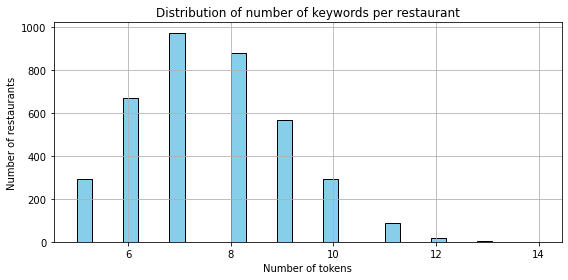

In [137]:
import matplotlib.pyplot as plt

# Display a few examples of cleaned keywords and tokens
# Afficher quelques exemples de mots-clés nettoyés et tokens
print("Sample tokenized keywords:")
display(df_valid[['restaurant_name', 'keywords_clean', 'tokens']].head())

# Display the dimensions of vectorized matrices
# Afficher les dimensions des matrices vectorisées
print("\n Vectorized representation shapes:")
print("TF-IDF shape   :", X_tfidf.shape)
print("BoW shape      :", X_bow.shape)
print("Word2Vec shape :", X_w2v.shape)
print("Doc2Vec shape  :", X_doc2vec.shape)

# Number of tokens per restaurant
# Nombre de tokens par restaurant
df_valid['nb_tokens'] = df_valid['tokens'].apply(len)

# Histogram of token length distribution
# Histogramme de la distribution des longueurs de mots-clés
plt.figure(figsize=(8, 4))
df_valid['nb_tokens'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of number of keywords per restaurant")  
plt.xlabel("Number of tokens") 
plt.ylabel("Number of restaurants") 
plt.grid(True)  
plt.tight_layout()  
plt.show()  


# Task 2.1 – Classification supervisée

### 2.1.1 Création de la variable cible

In [139]:
# Create a binary target variable: 1 if avg_rating >= 4, else 0
# Créer une variable cible binaire : 1 si note moyenne >= 4, sinon 0
df_valid['target'] = (df_valid['avg_rating'] >= 4).astype(int)
# This creates a new column 'target' where restaurants rated 4.0 or higher are labeled as 1 (positive),
# and those below 4.0 are labeled as 0 (negative).
# Cela crée une nouvelle colonne 'target' où les restaurants ayant une note ≥ 4.0 sont étiquetés 1 (positif),
# et ceux en dessous sont étiquetés 0 (négatif).

# Check class distribution
# Vérifier la répartition des classes
print("Target class distribution:")
print(df_valid['target'].value_counts())
# This shows how many restaurants are classified as well-rated (1) vs. poorly-rated (0),
# helping to identify any class imbalance before training models.
# Cela permet de voir combien de restaurants sont considérés comme bien notés (1) vs. mal notés (0),
# ce qui aide à détecter un éventuel déséquilibre de classes avant l'entraînement des modèles.


Target class distribution:
1    3409
0     386
Name: target, dtype: int64


### 2.1.2 Définition des modèles de classification

In [140]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Dictionary of models to test
# Dictionnaire des modèles à tester
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    # Linear and interpretable model, with class weighting to handle imbalance
    # Modèle linéaire et interprétable, pondéré pour gérer le déséquilibre de classes

    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    # Ensemble of decision trees, robust and handles nonlinearities well
    # Ensemble d'arbres de décision, robuste et efficace pour les relations non linéaires

    "Gradient Boosting": GradientBoostingClassifier(),
    # Boosting model that performs well on structured data, but sensitive to overfitting
    # Modèle de boosting performant sur données structurées, mais sensible à l’overfitting

    "Linear SVC": LinearSVC(class_weight='balanced'),
    # Linear SVM optimized for high-dimensional spaces like TF-IDF
    # SVM linéaire optimisé pour les espaces de haute dimension comme TF-IDF

    "Naive Bayes": MultinomialNB(),
    # Simple and fast model, assumes independence between features
    # Modèle simple et rapide, suppose l’indépendance des variables

    "KNN": KNeighborsClassifier(n_neighbors=5),
    # Classifies based on closest examples; intuitive but computationally expensive
    # Classe selon les voisins les plus proches ; intuitif mais coûteux à l’inférence

    "MLP (Neural Net)": MLPClassifier(max_iter=500, random_state=42)
    # Multi-layer perceptron: learns complex patterns, requires more tuning
    # Perceptron multicouche : apprend des relations complexes, nécessite plus de réglages
}

# Models not suited for dense vectors like Word2Vec and Doc2Vec
# Modèles à éviter pour les vecteurs denses comme Word2Vec et Doc2Vec
skip_models_for_dense = ["Naive Bayes"]
# Naive Bayes assumes discrete (sparse) inputs and fails on dense continuous embeddings
# Naive Bayes suppose des entrées discrètes (creuses) et échoue avec des plongements continus

dense_vecs = ['Word2Vec', 'Doc2Vec']
# Vectorization methods that produce dense (non-sparse) continuous vectors
# Méthodes de vectorisation produisant des vecteurs continus denses


### 2.1.3 Entraînement unique + stockage des résultats

In [141]:
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score, roc_curve,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split
from joblib import dump
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Global containers to store models, results, and predictions
# Conteneurs globaux pour sauvegarder les modèles, résultats et prédictions
trained_models_all = {}
all_results = []
y_test_saved = False  # to save y_test only once
# pour sauvegarder y_test une seule fois
all_predictions = []

def run_pipeline(X, vec_name):
    global trained_models_all, all_results, y_test_saved

    print(f" Running pipeline for: {vec_name}")
    
    # Split data into train and test
    # Division des données en train et test
    X_train, X_test, y_train, y_test = train_test_split(X, df_valid['target'], test_size=0.2, random_state=42)

    trained_models = {}
    model_outputs = []

    for model_name, model in models.items():
        # Skip models unsuitable for dense vectors
        # Sauter les modèles non compatibles avec les vecteurs denses
        if vec_name in dense_vecs and model_name in skip_models_for_dense:
            continue

        # Train the model
        # Entraîner le modèle
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

        # Evaluation metrics
        # Calcul des métriques d’évaluation
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        acc = accuracy_score(y_test, y_pred)
        f1_0 = report['0']['f1-score']
        f1_macro = report['macro avg']['f1-score']
        auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

        # Save model results
        # Sauvegarder les résultats du modèle
        trained_models[model_name] = {
            "model": model,
            "y_pred": y_pred,
            "y_proba": y_proba
        }

        model_outputs.append({
            "Vectorization": vec_name,
            "Model": model_name,
            "Accuracy": acc,
            "F1_class_0": f1_0,
            "F1_macro": f1_macro,
            "AUC": auc
        })

        # Save predictions for later use
        # Sauvegarde des prédictions
        df_pred = df_valid.iloc[y_test.index].copy()
        df_pred['target_pred'] = y_pred
        df_pred['score'] = y_proba if y_proba is not None else y_pred
        df_pred['vectorization'] = vec_name
        df_pred['model'] = model_name
        all_predictions.append(df_pred)

    # Save models and results globally
    # Enregistrement global des modèles et résultats
    trained_models_all[vec_name] = trained_models
    all_results.extend(model_outputs)

    # Save y_test once
    # Sauvegarder y_test une seule fois
    if not y_test_saved:
        pd.DataFrame({'target': y_test}).to_csv("y_test.csv", index=False)
        y_test_saved = True

    # Create DataFrame for metrics
    # Création du DataFrame des métriques
    df_results = pd.DataFrame(model_outputs).sort_values(by="F1_class_0", ascending=False)
    display(df_results.reset_index(drop=True))

    # Plot ROC curves
    # Affichage des courbes ROC
    plt.figure(figsize=(6, 4))
    for model_name, info in trained_models.items():
        y_proba = info['y_proba']
        if y_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            auc = roc_auc_score(y_test, y_proba)
            plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f"ROC Curve – {vec_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Display confusion matrices for each model
    # Affichage des matrices de confusion pour chaque modèle
    for model_name, info in trained_models.items():
        print(f"🔹 Confusion Matrix – {model_name}")
        ConfusionMatrixDisplay.from_predictions(y_test, info['y_pred'], cmap='Blues')
        plt.title(f"{model_name} ({vec_name})")
        plt.tight_layout()
        plt.show()

    # Barplot for F1 score (class 0)
    # Barplot du score F1 pour la classe 0
    df_plot = df_results.copy()
    df_plot['Label'] = df_plot['Model'] + f" ({vec_name})"
    df_plot = df_plot.sort_values(by='F1_class_0', ascending=False).head(10)

    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_plot, x="F1_class_0", y="Label", palette="viridis")
    plt.title(f"Top models – F1-score (class 0) – {vec_name}")
    plt.xlabel("F1-score (class 0)")
    plt.ylabel("Model")
    plt.tight_layout()
    plt.show()

    return df_results  # return local results for this vectorization


In [142]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA

# Target variable (for supervised feature selection)
# Variable cible (pour la sélection supervisée des variables)
y = df_valid['target']

# --- SelectKBest for TF-IDF and BoW (sparse matrices) ---
# --- SelectKBest pour TF-IDF et BoW (matrices creuses) ---

# Select 300 best features based on chi-squared test (TF-IDF)
# Sélection des 300 meilleures variables selon le test du chi² (TF-IDF)
selector_tfidf = SelectKBest(score_func=chi2, k=300)
X_tfidf_selected = selector_tfidf.fit_transform(X_tfidf, y)

# Same process for Bag of Words representation
# Même processus pour la représentation Bag of Words
selector_bow = SelectKBest(score_func=chi2, k=300)
X_bow_selected = selector_bow.fit_transform(X_bow, y)

# --- PCA for Word2Vec and Doc2Vec (dense matrices) ---
# --- PCA pour Word2Vec et Doc2Vec (matrices denses) ---

# Reduce to 50 components for Word2Vec embeddings
# Réduction à 50 composantes pour les vecteurs Word2Vec
pca_w2v = PCA(n_components=50, random_state=42)
X_w2v_reduced = pca_w2v.fit_transform(X_w2v)

# Reduce to 50 components for Doc2Vec embeddings
# Réduction à 50 composantes pour les vecteurs Doc2Vec
pca_doc2vec = PCA(n_components=50, random_state=42)
X_doc2vec_reduced = pca_doc2vec.fit_transform(X_doc2vec)


▶️ Running pipeline for: TF-IDF


,Vectorization,Model,Accuracy,F1_class_0,F1_macro,AUC
0,TF-IDF,Linear SVC,0.833992,0.370000,0.637200,NaN
1,TF-IDF,Logistic Regression,0.801054,0.328889,0.606053,0.759347
2,TF-IDF,MLP (Neural Net),0.884058,0.241379,0.589306,0.640819
3,TF-IDF,Random Forest,0.884058,0.137255,0.537554,0.601566
4,TF-IDF,Gradient Boosting,0.891963,0.046512,0.494625,0.644311
5,TF-IDF,KNN,0.889328,0.045455,0.493357,0.587484
6,TF-IDF,Naive Bayes,0.897233,0.000000,0.472917,0.807306


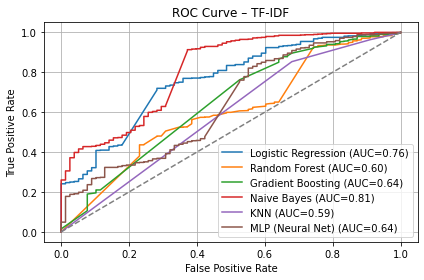

🔹 Confusion Matrix – Logistic Regression


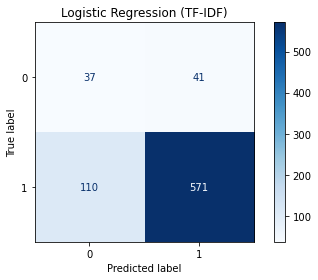

🔹 Confusion Matrix – Random Forest


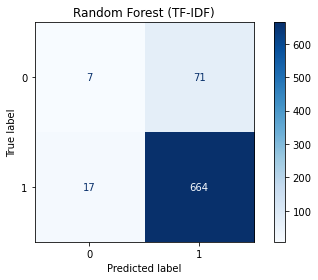

🔹 Confusion Matrix – Gradient Boosting


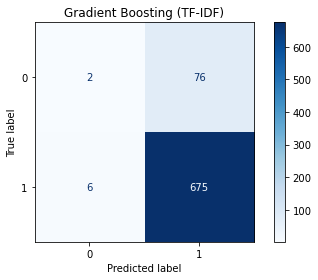

🔹 Confusion Matrix – Linear SVC


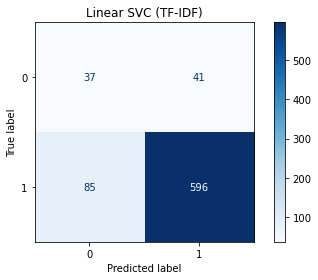

🔹 Confusion Matrix – Naive Bayes


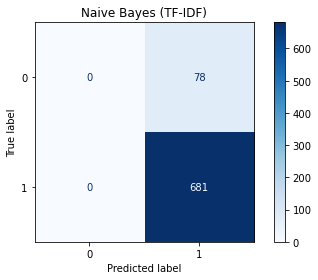

🔹 Confusion Matrix – KNN


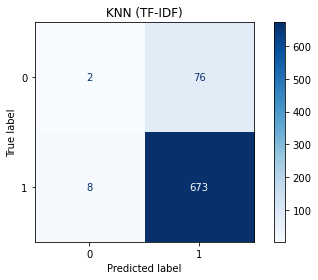

🔹 Confusion Matrix – MLP (Neural Net)


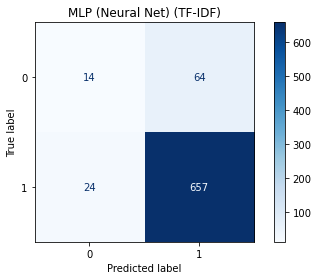

/tmp/ipykernel_5580/570477774.py:127: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




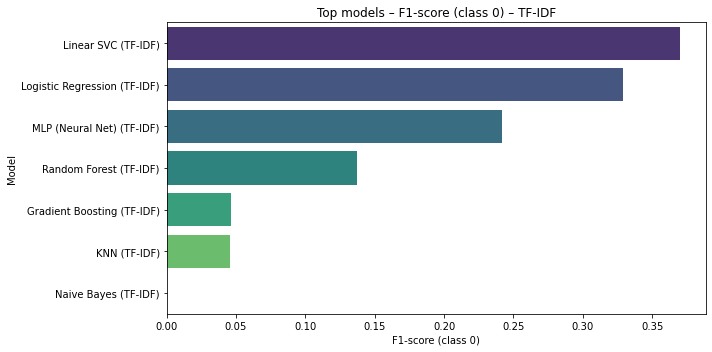

▶️ Running pipeline for: BoW


,Vectorization,Model,Accuracy,F1_class_0,F1_macro,AUC
0,BoW,Naive Bayes,0.910408,0.392857,0.672246,0.841946
1,BoW,Logistic Regression,0.787879,0.353414,0.613271,0.766915
2,BoW,Linear SVC,0.806324,0.328767,0.607802,NaN
3,BoW,MLP (Neural Net),0.870883,0.209677,0.569688,0.654919
4,BoW,Random Forest,0.866930,0.106195,0.517154,0.651286
5,BoW,Gradient Boosting,0.893281,0.024096,0.483825,0.671044
6,BoW,KNN,0.891963,0.000000,0.471448,0.532494


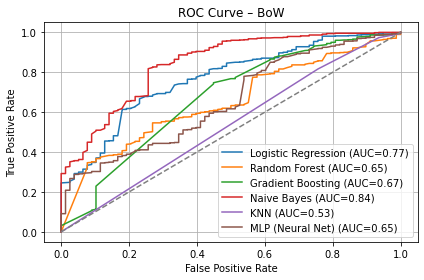

🔹 Confusion Matrix – Logistic Regression


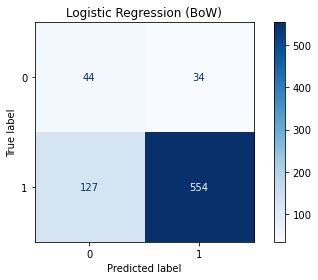

🔹 Confusion Matrix – Random Forest


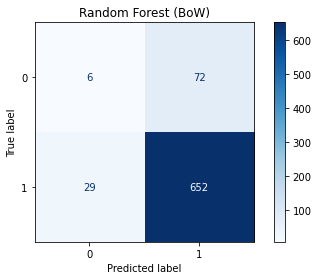

🔹 Confusion Matrix – Gradient Boosting


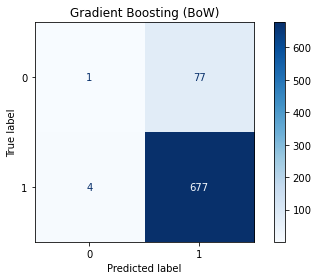

🔹 Confusion Matrix – Linear SVC


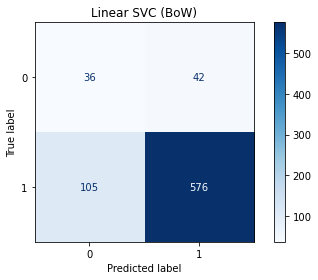

🔹 Confusion Matrix – Naive Bayes


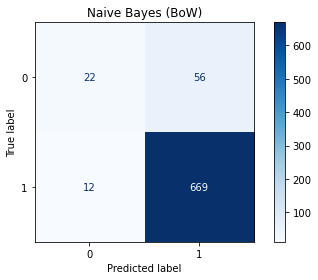

🔹 Confusion Matrix – KNN


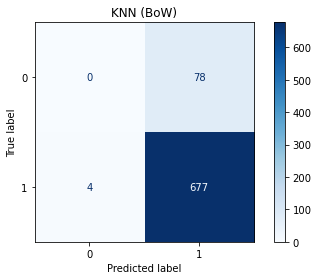

🔹 Confusion Matrix – MLP (Neural Net)


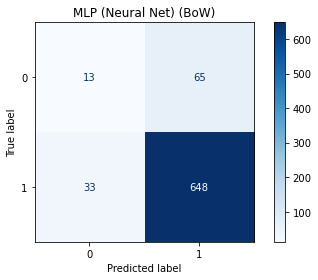

/tmp/ipykernel_5580/570477774.py:127: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




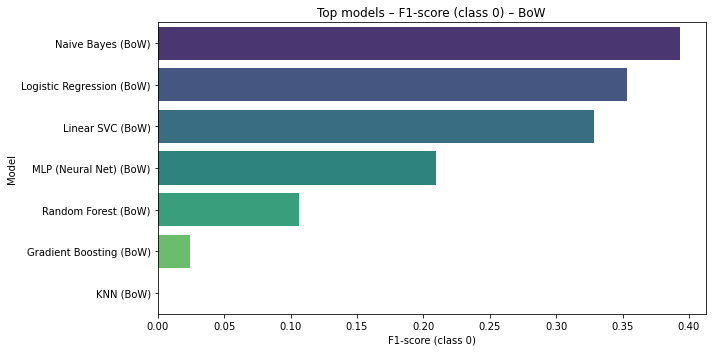

▶️ Running pipeline for: Word2Vec


,Vectorization,Model,Accuracy,F1_class_0,F1_macro,AUC
0,Word2Vec,Linear SVC,0.582345,0.250591,0.480547,NaN
1,Word2Vec,Logistic Regression,0.590250,0.235872,0.477972,0.612052
2,Word2Vec,KNN,0.890646,0.067416,0.504667,0.577375
3,Word2Vec,MLP (Neural Net),0.898551,0.025316,0.485904,0.664991
4,Word2Vec,Random Forest,0.897233,0.000000,0.472917,0.681436
5,Word2Vec,Gradient Boosting,0.889328,0.000000,0.470711,0.692025


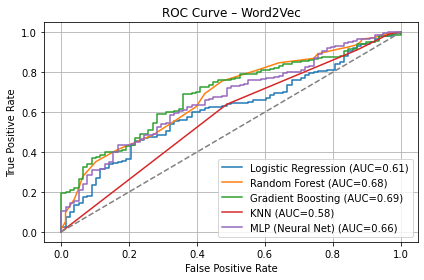

🔹 Confusion Matrix – Logistic Regression


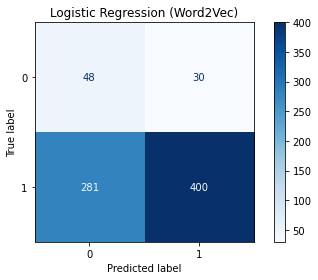

🔹 Confusion Matrix – Random Forest


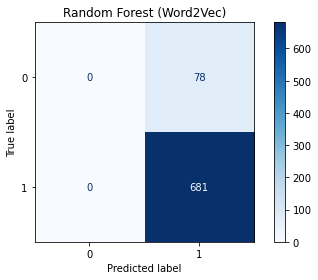

🔹 Confusion Matrix – Gradient Boosting


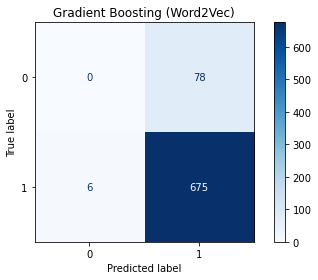

🔹 Confusion Matrix – Linear SVC


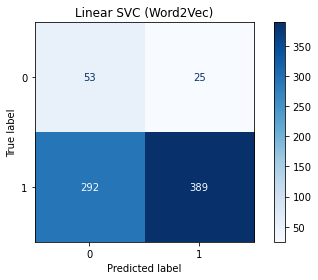

🔹 Confusion Matrix – KNN


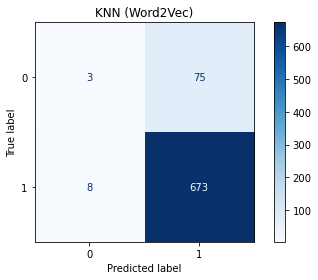

🔹 Confusion Matrix – MLP (Neural Net)


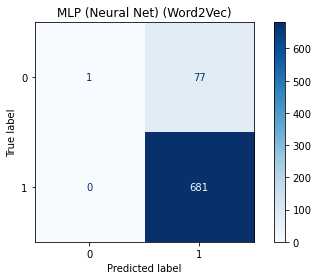

/tmp/ipykernel_5580/570477774.py:127: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




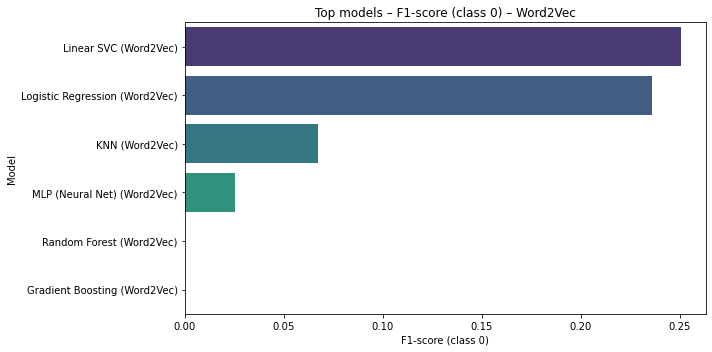

▶️ Running pipeline for: Doc2Vec


/home/jvollet/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



,Vectorization,Model,Accuracy,F1_class_0,F1_macro,AUC
0,Doc2Vec,Logistic Regression,0.636364,0.277487,0.517265,0.719342
1,Doc2Vec,Linear SVC,0.627141,0.261097,0.505879,NaN
2,Doc2Vec,KNN,0.888011,0.158416,0.549215,0.593189
3,Doc2Vec,MLP (Neural Net),0.873518,0.142857,0.537289,0.665707
4,Doc2Vec,Gradient Boosting,0.897233,0.071429,0.508518,0.674065
5,Doc2Vec,Random Forest,0.897233,0.000000,0.472917,0.688646


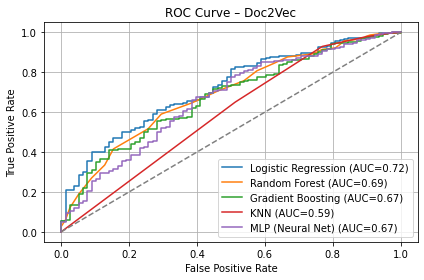

🔹 Confusion Matrix – Logistic Regression


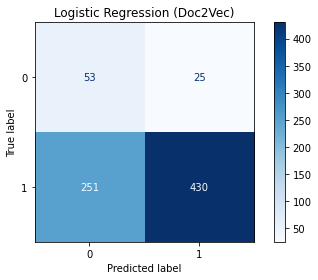

🔹 Confusion Matrix – Random Forest


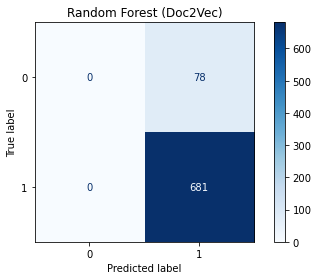

🔹 Confusion Matrix – Gradient Boosting


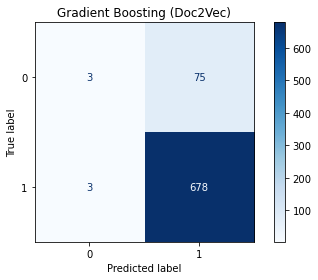

🔹 Confusion Matrix – Linear SVC


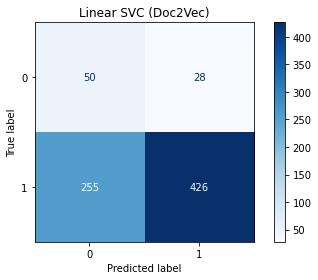

🔹 Confusion Matrix – KNN


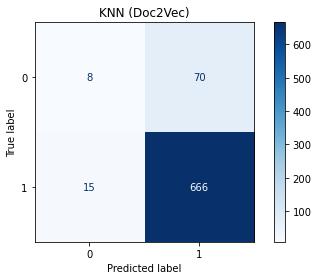

🔹 Confusion Matrix – MLP (Neural Net)


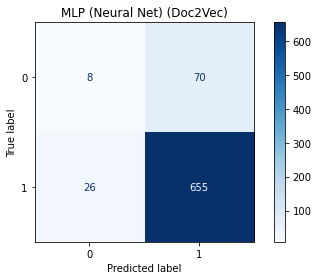

/tmp/ipykernel_5580/570477774.py:127: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




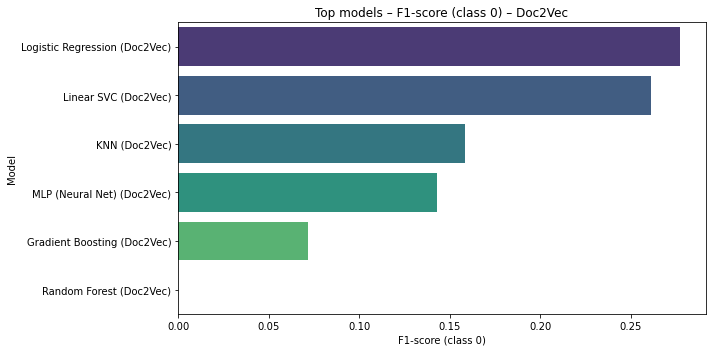

In [143]:
df_tf = run_pipeline(X_tfidf_selected, "TF-IDF")
df_bow = run_pipeline(X_bow_selected, "BoW")
df_w2v = run_pipeline(X_w2v_reduced, "Word2Vec")
df_doc2vec = run_pipeline(X_doc2vec_reduced, "Doc2Vec")


In [144]:
# Finaliser les sauvegardes après tous les run_pipeline(...)
df_all_results = pd.DataFrame(all_results)
df_all_results.to_csv("data/df_results.csv", index=False)
dump(trained_models_all, "data/trained_models.joblib")

print(" Tous les résultats ont été sauvegardés.")


✅ Tous les résultats ont été sauvegardés.


In [145]:
df_all_preds = pd.concat(all_predictions, ignore_index=True)
df_all_preds.to_csv("data/restaurants_with_all_predictions.csv", index=False)
print(" Prédictions enregistrées pour Dash.")


✅ Prédictions enregistrées pour Dash.


,Vectorization,Model,Accuracy,F1_class_0,F1_macro,AUC
7,BoW,Naive Bayes,0.910408,0.392857,0.672246,0.841946
0,TF-IDF,Linear SVC,0.833992,0.370000,0.637200,NaN
8,BoW,Logistic Regression,0.787879,0.353414,0.613271,0.766915
1,TF-IDF,Logistic Regression,0.801054,0.328889,0.606053,0.759347
9,BoW,Linear SVC,0.806324,0.328767,0.607802,NaN
20,Doc2Vec,Logistic Regression,0.636364,0.277487,0.517265,0.719342
21,Doc2Vec,Linear SVC,0.627141,0.261097,0.505879,NaN
14,Word2Vec,Linear SVC,0.582345,0.250591,0.480547,NaN
2,TF-IDF,MLP (Neural Net),0.884058,0.241379,0.589306,0.640819
15,Word2Vec,Logistic Regression,0.590250,0.235872,0.477972,0.612052


/tmp/ipykernel_5580/690575163.py:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




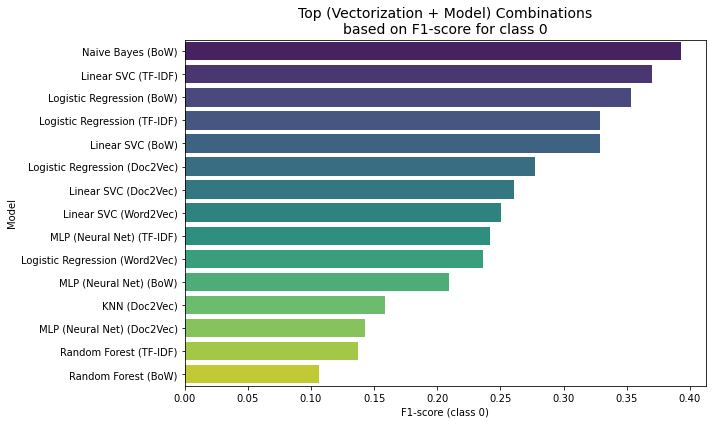

In [146]:
# Merge all evaluation results from different vectorizations
# Fusionner tous les résultats d'évaluation issus des différentes vectorisations
df_all = pd.concat([df_tf, df_bow, df_w2v, df_doc2vec], ignore_index=True)

# Display top 10 models across all vectorizations based on F1-score for class 0
# Afficher les 10 meilleurs modèles toutes vectorisations confondues (selon le F1-score classe 0)
top_f1_class0 = df_all.sort_values(by="F1_class_0", ascending=False).head(10)
display(top_f1_class0)

import seaborn as sns
import matplotlib.pyplot as plt

# Add a new column combining model name and vectorization method
# Ajouter une colonne combinant le nom du modèle et la méthode de vectorisation
df_all['Label'] = df_all['Model'] + " (" + df_all['Vectorization'] + ")"

# Select top 15 combinations for clearer visualization
# Sélectionner les 15 meilleures combinaisons pour une meilleure lisibilité
df_plot = df_all.sort_values(by="F1_class_0", ascending=False).head(15)

# Plot a horizontal bar chart showing the best combinations based on F1-score for class 0
# Tracer un barplot horizontal des meilleures combinaisons selon le F1-score (classe 0)
plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x="F1_class_0", y="Label", palette="viridis")
plt.title("Top (Vectorization + Model) Combinations\nbased on F1-score for class 0", fontsize=14)
plt.xlabel("F1-score (class 0)")
plt.ylabel("Model")
plt.tight_layout()
plt.show()


# Task 2.2 – Topic Modeling (LDA)

In [147]:
from sklearn.feature_extraction.text import CountVectorizer
df_valid = pd.read_csv('data/restaurants_france_clean.csv')

# Clean keywords for LDA
# Nettoyage du texte pour LDA
df_valid['keywords_clean'] = df_valid['keywords'].fillna('').str.lower()

# Vectorize with CountVectorizer (no TF-IDF here)
# Vectoriser avec CountVectorizer (sans pondération TF-IDF)
# We set:
# - max_df=0.95 to ignore terms too frequent (appear in more than 95% of documents)
# - min_df=2 to remove very rare terms (appear in only 1 document)
# - stop_words='english' to remove common English words
# Paramètres :
# - max_df=0.95 : ignore les termes trop fréquents
# - min_df=2 : ignore les mots très rares
# - stop_words='english' : supprime les mots vides usuels en anglais
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X_counts = count_vectorizer.fit_transform(df_valid['keywords_clean'])

# Show matrix shape
# Affichage de la forme de la matrice de documents (restaurants × mots)
print("Count matrix shape:", X_counts.shape)


Count matrix shape: (3795, 1493)


Coherence score for 2 topics: 0.1580
Coherence score for 3 topics: 0.1533
Coherence score for 4 topics: 0.1856
Coherence score for 5 topics: 0.2123
Coherence score for 6 topics: 0.1973
Coherence score for 7 topics: 0.1918
Coherence score for 8 topics: 0.1830
Coherence score for 9 topics: 0.1957
Coherence score for 10 topics: 0.1981
Coherence score for 11 topics: 0.1870
Coherence score for 12 topics: 0.2342
Coherence score for 13 topics: 0.2287
Coherence score for 14 topics: 0.2194
Coherence score for 15 topics: 0.2305
Coherence score for 16 topics: 0.2389
Coherence score for 17 topics: 0.2503
Coherence score for 18 topics: 0.2587
Coherence score for 19 topics: 0.2345
Coherence score for 20 topics: 0.2600


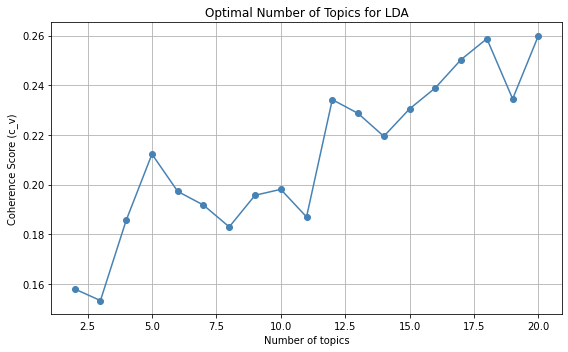

In [148]:
from gensim.models import CoherenceModel, LdaModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt

# Prepare tokenized texts for Gensim
# Préparation des textes tokenisés pour Gensim
texts = df_valid['keywords'].fillna('').str.lower().apply(lambda x: x.split()).tolist()

# Create dictionary and corpus for LDA
# Création du dictionnaire et du corpus à partir des textes
# - dictionary : mappe chaque mot unique à un identifiant
# - corpus : liste des documents sous forme de "bag-of-words"
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Try different values of k (number of topics)
# Essayer différents nombres de topics (k de 2 à 20)
coherence_scores = []
topics_range = range(2, 21)

for k in topics_range:
    # Train LDA model with k topics
    # Entraîner un modèle LDA avec k topics
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=k, random_state=42)

    # Compute coherence score (c_v)
    # Calculer le score de cohérence basé sur la similarité des mots dans chaque topic
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    score = coherence_model.get_coherence()
    coherence_scores.append(score)
    print(f"Coherence score for {k} topics: {score:.4f}") 

# Plot coherence vs number of topics
# Tracer l'évolution du score de cohérence en fonction du nombre de topics
plt.figure(figsize=(8, 5))
plt.plot(topics_range, coherence_scores, marker='o', color='steelblue')
plt.xlabel('Number of topics')
plt.ylabel('Coherence Score (c_v)')
plt.title('Optimal Number of Topics for LDA')
plt.grid(True)
plt.tight_layout()
plt.show()


In [149]:
from sklearn.decomposition import LatentDirichletAllocation

# Définir le nombre de topics (6)
# Define number of topics (6)
n_topics = 6

# Entraîner le modèle LDA
# Train the LDA model
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_model.fit(X_counts)


LatentDirichletAllocation(n_components=6, random_state=42)

In [150]:
# Fonction pour récupérer les top mots pour chaque topic
def get_sklearn_lda_keywords(model, feature_names, topn=10):
    topic_keywords = {}
    for topic_idx, topic in enumerate(model.components_):
        top_features_idx = topic.argsort()[:-topn - 1:-1]
        top_words = [feature_names[i] for i in top_features_idx]
        topic_keywords[topic_idx] = top_words
    return topic_keywords

# Exemple d'utilisation
feature_names = count_vectorizer.get_feature_names_out()
topic_keywords = get_sklearn_lda_keywords(lda_model, feature_names, topn=10)

# Aperçu
for topic, words in topic_keywords.items():
    print(f"Topic {topic}: {', '.join(words)}")


Topic 0: restaurant, salad, foie, gras, pizza, food, cream, ice, small, lunch
Topic 1: food, excellent, meal, lunch, chef, lovely, delicious, night, great, english
Topic 2: lunch, wine, restaurant, salad, great, steak, duck, burger, atmosphere, list
Topic 3: food, service, great, friendly, salad, pasta, pizza, restaurant, nice, burger
Topic 4: menu, wine, course, bouche, amuse, main, michelin, tasting, foie, gras
Topic 5: steak, salad, soup, duck, potatoes, bread, onion, fries, escargot, french


In [151]:
# Calculer la distribution des topics pour chaque ligne
# Compute topic distribution for each sample
lda_topics = lda_model.transform(X_counts)

# Choisir le topic avec la probabilité maximale
# Assign the topic with the highest probability
df_valid['dominant_topic'] = lda_topics.argmax(axis=1)

# Aperçu
df_valid[['restaurant_name', 'dominant_topic']].head()


,restaurant_name,dominant_topic
0,Le Napoléon,2
1,Les Clos de Paulilles,1
2,Le Café Comptoir,1
3,Auberge de la Mole,4
4,Chez Moran,1


In [152]:
# Sauvegarder le fichier enrichi avec les topics
# Save enriched dataset with dominant topics
df_valid.to_csv("data/restaurants_france_valid_topic.csv", index=False)
topic_cols = [col for col in df.columns if col.startswith("topic_")]
df["dominant_topic"] = df[topic_cols].idxmax(axis=1)
df["dominant_topic"] = df["dominant_topic"].str.extract("(\d+)").astype(int)

# Et ensuite :
df.to_csv("data/restaurants_france_valid_topic.csv", index=False)


In [153]:
import joblib

# Sauvegarde
joblib.dump(lda_model, "data/lda_model.joblib")
joblib.dump(count_vectorizer, "data/count_vectorizer.joblib")


['data/count_vectorizer.joblib']

# Dashbord

In [154]:
import dash
from dash import dcc, html, Input, Output
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from joblib import load

# Load saved data
df_results = pd.read_csv("data/df_results.csv")
trained_models = load("data/trained_models.joblib")
y_test = pd.read_csv("data/y_test.csv")["target"]

# Initialize Dash app
app = dash.Dash(__name__)
app.title = "Classification Evaluation Dashboard – AML"

# Layout
app.layout = html.Div([
    html.H1("📊 Classification Model Evaluation Dashboard", style={"textAlign": "center"}),

    html.Div([
        html.Label("Select a vectorization method:"),
        dcc.Dropdown(
            id='vec-selector',
            options=[{'label': v, 'value': v} for v in df_results["Vectorization"].unique()],
            value="TF-IDF"
        ),

        html.Label("Select a model:"),
        dcc.Dropdown(id='model-selector')
    ], style={"width": "50%", "margin": "auto"}),

    dcc.Graph(id='roc-curve'),
    dcc.Graph(id='confusion-matrix'),
    dcc.Graph(id='bar-metrics')
])

# Update model dropdown based on selected vectorization
@app.callback(
    Output('model-selector', 'options'),
    Output('model-selector', 'value'),
    Input('vec-selector', 'value')
)
def update_model_dropdown(selected_vec):
    available_models = list(trained_models[selected_vec].keys())
    options = [{'label': m, 'value': m} for m in available_models]
    return options, available_models[0]

# Update ROC curve, confusion matrix, and metrics barplot
@app.callback(
    Output('roc-curve', 'figure'),
    Output('confusion-matrix', 'figure'),
    Output('bar-metrics', 'figure'),
    Input('vec-selector', 'value'),
    Input('model-selector', 'value')
)
def update_dashboard(vectorization, model_name):
    model_data = trained_models[vectorization][model_name]
    y_pred = model_data["y_pred"]
    y_proba = model_data["y_proba"]

    # ROC curve
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_score = roc_auc_score(y_test, y_proba)
        fig_roc = go.Figure()
        fig_roc.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f"AUC = {auc_score:.2f}"))
        fig_roc.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random', line=dict(dash='dash')))
        fig_roc.update_layout(title="ROC Curve", xaxis_title="False Positive Rate", yaxis_title="True Positive Rate")
    else:
        fig_roc = go.Figure()
        fig_roc.update_layout(title="No probability scores available for this model.")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    fig_cm = px.imshow(
        cm, text_auto=True, color_continuous_scale='Blues',
        labels=dict(x="Predicted", y="Actual"),
        title="Confusion Matrix"
    )

    # Metric barplot
    metrics = df_results[
        (df_results["Model"] == model_name) &
        (df_results["Vectorization"] == vectorization)
    ].iloc[0]

    fig_bar = go.Figure([
        go.Bar(name="Accuracy", x=["Accuracy"], y=[metrics["Accuracy"]]),
        go.Bar(name="F1 Macro", x=["F1 Macro"], y=[metrics["F1_macro"]]),
        go.Bar(name="AUC", x=["AUC"], y=[metrics["AUC"]])
    ])
    fig_bar.update_layout(title="Model Metrics", barmode='group')

    return fig_roc, fig_cm, fig_bar

# Run the app
if __name__ == '__main__':
    app.run(debug=True, port=8050)


In [157]:
import dash
from dash import dcc, html, Input, Output
import pandas as pd
import plotly.express as px
import joblib

# === 🔁 Load data and models ===
df = pd.read_csv("data/restaurants_france_valid_topic.csv")
lda_model = joblib.load("data/lda_model.joblib")
count_vectorizer = joblib.load("data/count_vectorizer.joblib")

# === ✅ Generate keywords per topic ===
def get_sklearn_lda_keywords(model, feature_names, topn=10):
    topic_keywords = {}
    for topic_idx, topic in enumerate(model.components_):
        top_features_idx = topic.argsort()[:-topn - 1:-1]
        top_words = [feature_names[i] for i in top_features_idx]
        topic_keywords[topic_idx] = top_words
    return topic_keywords

feature_names = count_vectorizer.get_feature_names_out()
topic_keywords = get_sklearn_lda_keywords(lda_model, feature_names, topn=10)
num_topics = lda_model.n_components

# === 🌐 Initialize Dash app ===
app = dash.Dash(__name__)
app.title = "LDA Topic Dashboard – sklearn"

app.layout = html.Div([
    html.H1("📊 LDA Topic Analysis (Restaurants)", style={"textAlign": "center"}),

    dcc.Dropdown(
        id='city-filter',
        options=[{'label': c, 'value': c} for c in sorted(df['city'].dropna().unique())],
        value=None,
        placeholder="Filter by city...",
        multi=True
    ),

    dcc.Dropdown(
        id='topic-filter',
        options=[{'label': f"Topic {i}", 'value': i} for i in range(num_topics)],
        value=None,
        placeholder="Filter by topic..."
    ),

    dcc.Graph(id="topic-bar"),
    html.Div(id="keywords-display", style={"textAlign": "center", "fontSize": "18px", "marginTop": "20px"}),

    dcc.Graph(id="map-lda")
])

@app.callback(
    Output("topic-bar", "figure"),
    Output("map-lda", "figure"),
    Input("city-filter", "value"),
    Input("topic-filter", "value")
)
def update_graphs(selected_cities, selected_topic):
    filtered_df = df.copy()
    if selected_cities:
        filtered_df = filtered_df[filtered_df["city"].isin(selected_cities)]
    if selected_topic is not None:
        filtered_df = filtered_df[filtered_df["dominant_topic"] == selected_topic]

    fig_hist = px.histogram(df if not selected_cities else df[df['city'].isin(selected_cities)],
                            x='dominant_topic', nbins=num_topics,
                            title="Topic Distribution (LDA)")
    fig_hist.update_layout(xaxis_title="Topic", yaxis_title="Number of restaurants")

    fig_map = px.scatter_mapbox(
        filtered_df,
        lat="latitude",
        lon="longitude",
        color="dominant_topic",
        hover_name="restaurant_name",
        hover_data=["city", "avg_rating", "price_level"],
        mapbox_style="open-street-map",
        zoom=4,
        title="Restaurants filtered by topic (LDA)"
    )

    return fig_hist, fig_map

@app.callback(
    Output("keywords-display", "children"),
    Input("topic-filter", "value")
)
def show_keywords(selected_topic):
    if selected_topic is not None:
        words = topic_keywords.get(selected_topic, [])
        return f"🧠 Topic {selected_topic}: {', '.join(words)}"
    return "🧠 Select a topic to display its keywords."

if __name__ == '__main__':
    app.run(debug=True, port=8051)


/tmp/ipykernel_5580/2399784285.py:71: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [158]:
import dash
from dash import dcc, html, Input, Output
import pandas as pd
import plotly.express as px

# Load predictions from all model/vector combinations
df = pd.read_csv("data/restaurants_with_all_predictions.csv")

# Initialize Dash app
app = dash.Dash(__name__)
app.title = "Restaurant Recommendation – Multi-Model Comparison"

# Layout
app.layout = html.Div([
    html.H1("🍴 Restaurant Recommendations (Model + Vectorization Selection)", style={"textAlign": "center"}),

    html.Div([
        html.Label("Select vectorization method:"),
        dcc.Dropdown(
            id='vec-dropdown',
            options=[{"label": v, "value": v} for v in sorted(df['vectorization'].unique())],
            value=sorted(df['vectorization'].unique())[0]
        ),
    ], style={"width": "48%", "display": "inline-block"}),

    html.Div([
        html.Label("Select classification model:"),
        dcc.Dropdown(
            id='model-dropdown',
            options=[{"label": m, "value": m} for m in sorted(df['model'].unique())],
            value=sorted(df['model'].unique())[0]
        ),
    ], style={"width": "48%", "display": "inline-block", "float": "right"}),

    html.Br(),
    dcc.Graph(id='map-restaurant'),

    html.Br(),
    html.Div(id='tables-container')
])

# Callback
@app.callback(
    Output('map-restaurant', 'figure'),
    Output('tables-container', 'children'),
    Input('vec-dropdown', 'value'),
    Input('model-dropdown', 'value')
)
def update_dashboard(selected_vec, selected_model):
    # Filter
    filtered_df = df[(df['vectorization'] == selected_vec) & (df['model'] == selected_model)]

    # Map for predicted good restaurants only
    map_df = filtered_df[filtered_df['target_pred'] == 1]
    fig = px.scatter_map(
        map_df,
        lat='latitude',
        lon='longitude',
        hover_name='restaurant_name',
        hover_data=['city', 'avg_rating', 'keywords_clean', 'score'],
        color='score',
        color_continuous_scale='Blues',
        zoom=4,
        height=500,
        title=f"Recommended Restaurants ({selected_model} + {selected_vec})"
    )

    # Top 10 recommended restaurants
    top_df = map_df.sort_values(by='score', ascending=False).head(10)
    top_table = html.Table([
        html.Thead(html.Tr([html.Th(col) for col in ['Name', 'City', 'Avg Rating', 'Keywords', 'Score', 'Predicted Class']])),
        html.Tbody([
            html.Tr([
                html.Td(top_df.iloc[i]['restaurant_name']),
                html.Td(top_df.iloc[i]['city']),
                html.Td(f"{top_df.iloc[i]['avg_rating']:.1f}"),
                html.Td(top_df.iloc[i]['keywords_clean']),
                html.Td(f"{top_df.iloc[i]['score']:.2f}"),
                html.Td(str(top_df.iloc[i]['target_pred']))
            ]) for i in range(len(top_df))
        ])
    ])

    # Bottom 10 least recommended restaurants
    bottom_df = filtered_df[filtered_df['target_pred'] == 0].sort_values(by='score', ascending=True).head(10)
    bottom_table = html.Table([
        html.Thead(html.Tr([html.Th(col) for col in ['Name', 'City', 'Avg Rating', 'Keywords', 'Score', 'Predicted Class']])),
        html.Tbody([
            html.Tr([
                html.Td(bottom_df.iloc[i]['restaurant_name']),
                html.Td(bottom_df.iloc[i]['city']),
                html.Td(f"{bottom_df.iloc[i]['avg_rating']:.1f}"),
                html.Td(bottom_df.iloc[i]['keywords_clean']),
                html.Td(f"{bottom_df.iloc[i]['score']:.2f}"),
                html.Td(str(bottom_df.iloc[i]['target_pred']))
            ]) for i in range(len(bottom_df))
        ])
    ])

    tables = html.Div([
        html.H3("📈 Top 10 Recommended Restaurants"),
        top_table,
        html.Br(),
        html.H3("📉 Bottom 10 Restaurants According to the Model"),
        bottom_table
    ])

    return fig, tables

# Run app
if __name__ == '__main__':
    app.run(debug=True, port=8052)
